In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
# Load in the iris dataset
iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=42)

In [3]:
torch.manual_seed(42)

# Port over to torch tensors
X_train_std = torch.tensor((X_train - np.mean(X_train)) / np.std(X_train), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test_std = torch.tensor((X_test - np.mean(X_train)) / np.std(X_train), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_std, y_train)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)

In [4]:
# Create the model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        # Initialize the nn.Module attributes
        super().__init__()
        
        # Create nn layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Pass the input through the linear layer
        x = self.layer1(x)
        # Use a sigmoid activation in between
        x = nn.Sigmoid()(x)
        # Use a final linear combination of the sigmoids
        x = self.layer2(x)
        return x

input_size = X_train_std.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

In [5]:
# Set training parameters and functions
learning_rate = 1e-3
num_epochs = 200

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Store loss and accuracy along the way
loss_hist, acc_hist = [0] * num_epochs, [0] * num_epochs

# Training loop
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:

        pred = model(x_batch) # predict
        loss = loss_func(pred, y_batch) # compute loss
        loss.backward() # automatic differentiation of the loss w.r.t parameters with requires_grad

        optimizer.step()
        optimizer.zero_grad()
        
        # Store metrics
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        correct_preds = (torch.argmax(pred, dim=1) == y_batch).float()
        acc_hist[epoch] += correct_preds.sum()
    
    # Create epoch averages of metrics
    loss_hist[epoch] /= len(train_dl.dataset)
    acc_hist[epoch] /= len(train_dl.dataset)

    if not epoch % 10:
        print(f"Epoch {epoch}: Loss = {loss_hist[epoch]:.4f}")

print("Training Complete")

Epoch 0: Loss = 1.1248
Epoch 10: Loss = 0.8467
Epoch 20: Loss = 0.5755
Epoch 30: Loss = 0.4445
Epoch 40: Loss = 0.3602
Epoch 50: Loss = 0.2996
Epoch 60: Loss = 0.2557
Epoch 70: Loss = 0.2231
Epoch 80: Loss = 0.1988
Epoch 90: Loss = 0.1793
Epoch 100: Loss = 0.1646
Epoch 110: Loss = 0.1526
Epoch 120: Loss = 0.1428
Epoch 130: Loss = 0.1348
Epoch 140: Loss = 0.1291
Epoch 150: Loss = 0.1226
Epoch 160: Loss = 0.1194
Epoch 170: Loss = 0.1122
Epoch 180: Loss = 0.1077
Epoch 190: Loss = 0.1037
Training Complete


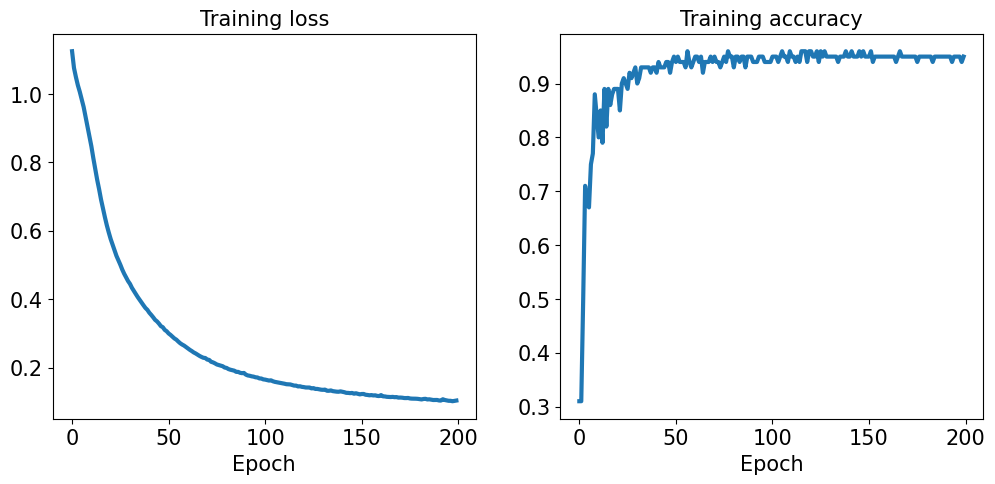

In [7]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(acc_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [8]:
pred_test = model(X_test_std)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 1.0000


In [9]:
# The model parameters can now be saved with torch.save as a pt or pth file
path = 'iris_classifier.pt'
torch.save(model, path)

model_new = torch.load(path)
print(model_new.eval())

# # Optionally, we can save just the model parameters
# path = 'iris_classifier_state.pt'
# torch.save(model.state_dict(), path)

# # To load this, we need to first reconstruct the new model and then load the parameters into it
# model_new = Model(input_size, hidden_size, output_size)
# model_new.load_state_dict(torch.load(path))

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)


C:\Users\sadit\AppData\Local\Temp\ipykernel_7508\3252404016.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new = torch.load(path)
